<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Advanced Statistics for Physics Analysis<b> </div>
<div style="text-align:right"><strong>Year: </strong>2022-2023<b> </div>
<div style="text-align:right"><strong>Professor in charge: </strong> Alberto Garfagnini<b> </div>
    

#### Students:
- Bedin Veronica - 2097013 - veronica.bedin.1@studenti.unipd.it <br>
- Marchetti Andrea - 2089216 - andrea.marchetti.5@studenti.unipd.it <br>
- Merlin Giovanni - 2091186 - giovanni.merlin@studenti.unipd.it <br>

    
<strong>Exam Date</strong>: 14th  of September 2023
    
<center>
    
## P06 - Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm
    
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">

# Introduction
A Bayesian belief network is defined as a pair ($B_s$, $B_p$), where $B_s$ defines its structure, i. e. its sets of nodes $\{x_i\}$, while $B_p$ encodes a list of conditional probabilities on the nodes [Cooper & Herskovits, 1992]. Such conditional probabilities relate each node $x_i$ to its parents $\pi_i$: $P(X_i | \Pi_i)$, where with $X_i$, $\Pi_i $ we indicate any instantiation of variable $x_i$, resp. $\pi_i$.
In particular, the joint probability of a specific instantiation $(X_1, \dots , X_n)$ of the network can be calculated as the product of all the probabilities of the instantiations of single nodes given their parents:

$P(X_1, \dots , X_n) = \prod_{i = 1}^{n} P(X_i | \Pi_i)$

Nevertheless, the construction of belief networks – i. e. the individuation of all the parentship relations – remains in most cases a time-consuming and inefficient task, which must be performed manually. Efficient techniques for automatic inference are still under development.
To construct the network automatically given a set of possible belief network structures $B_{S1},\dots,B_{Sm}$ and a dataset $D$, one must be able to compute and compare all conditional probabilities $P(B_{Si} | D)$, and then choose the structure that best explains the data. However, the number of different possible structures to probe grows exponentially with the number of nodes. For this reason, we must rely on heuristic methods, like the K2 algorithm.

In [24]:
# load the required libraries
suppressWarnings({
    library("furrr")
    library(future)
    library("tidyr")
    library("dplyr")
    library(gmp) 
    library(bnstruct)
    library(bnlearn)
    library(graph)
    library(Rgraphviz)
    library("graph")
    library(ggplot2) })

# set parameters for parallel processing
plan(multisession, workers = 7)

# Index:
1. [K2-algortithm implementation](#K2)
2. [Application on Ruiz dataset](#K2_Ruiz)
3. [Application on Child dataset](#Child)
4. [Application on Asia dataset](#Asia)

<a id='K2'></a>
# 1. K2 algorithm

### The K2 algorithm
For discrete-variable networks, we can develop a greedy-search method to find the structure with the highest probability to explain the data as described in the following.
Being discrete, each variable $x_i$ can assume a number of different values from 1 to $V_i$. The algorithm starts from the assumption that each network’s node has initially no parents, and then cycles over the nodes determining for each the list of parents that increases the most the probability of the resulting structure. In particular, the probability that a node $x_i$, has parents $\pi_i$ is calculated as:

$f(x_i, \pi_i) = \prod_{j = 1}^{q_i} \dfrac{(r_i – 1)!}{(N_{ij} + r_i – 1)!} \prod_{k = 1}^{r_i} \alpha_{ijk}!$

where:
-	$q_i$ is the number of different possible combinations of the values of the parents $\pi_i$ of $x_i$, i. e. it is the cardinality of the Cartesian product of all the possible values of the parents;
-	$r_i$ is the number of different possible values of $x_i$;
-	$\alpha_{ijk}$ is the number of cases in the dataset $D$ in which $x_i = k$, with $k \in \{1,\dots,V_i\}$ _and_ the parents assume values corresponding to their $j$-th possible instantiation, with $j \in \{1,\dots, q_i\}$;
-	$N_{ij} = \sum_{k = 1}^{r_i} \alpha_{ijk}$ i.e., it is the number of cases in the database in which the parents in $\pi_i$ are instantiated with their $j$-th possible instantiation, independently of the value of $x_i$.
In addition, when $\pi_i = \emptyset$, the product over $j$ is neglected, and $N_{ij}$ and $\alpha_{ijk}$ are calculated only on the values of $x_i$ and independently of the values of the parents.

The algorithm proceeds starting from a list in which the nodes are ordered by hand in such a way that subsequent nodes cannot be the parents of preceding nodes. The algorithm then cycles over this list, and for each node: it starts from the assumption that it has no parents, then adds incrementally the parent
whose addition most increases the probability of the resulting structure – i. e. that, added to the already existing parents, returns the highest value of $f$ - until a maximum number of parents $u$ (set by the user) is reached or there is no improvement.
A schematised version of the algorithm, with inputs, outputs and pseudocode, is presented below.

***Input***: 
- A set of $n$ nodes,
- an ordering on the nodes,
- an upper bound $u$ on the number of parents a node may have
- a database $D$ containing $m$ cases.

***Output***: For each node, a printout of the parents of the node.

***Algorithm***:

![Alg](K-2-new.png)

In [3]:
# return a matrix with the cartesian product of all the possible values of the parents in the given list 'p_i'
# SIMPLIFYING ASSUMPTIONS: 
# - the values that each node can assume go EXACTLY from 1 to the node's size
# - the node's size is at least 2 (o/w it would make no sense to search for relations)

phi = function(D, p_i){
    
    # get the number of possible different values for all variables in the database
    ns = node.sizes(D)
    
    # create a list whose j-th element is a vector with the possible values that parent j can assume
    p_vals = list()
    for(p in p_i){

        p_vals = append(p_vals, list(1:ns[p]))
    }

    # create the cartesian product, and cast it from dataframe into an unnamed matrix
    cartp = as.matrix(expand.grid(p_vals))
    colnames(cartp) = NULL
    
    return(cartp)
}

In [4]:
# alpha
alphas = function(D, i, p_i=NULL, phi_ij=NULL){
    
    # get the number of possible different values for all variables in the database
    ns = node.sizes(D)

    # convert the BNDataset onto a normal dataframe for manipulation
    Ddf = data.frame(raw.data(D))

    # save all alpha_ijk's in a unique vector. Each element of the vector will be associated
    # to the same (the j-th) combination of parent's possible values, and will correspond
    # to a different value of node 'i'
    alphas_ij = c() 

    # cycle over the possible values of node 'i'
    for(k in 1:ns[i]){

        # filter the dataset keeping only the specified values for 'i' and its parents:
        # 'k' for 'i' and the j-th combination 'phi_ij' for the parents 'p_i'.
        # The selection for the parents is done one parent at a time
        Dfilt = filter(Ddf, Ddf[i] == k)
        
        # first check if 'i' has any parent
        if(!is.null(p_i)){for(p in 1:length(p_i)){Dfilt = filter(Dfilt, Dfilt[p_i[p]] == phi_ij[p])}}        

        # 'alpha_ijk' is the number of rows of the filtered dataset. Append it to the vector
        alphas_ij = append(alphas_ij, nrow(Dfilt))
    }

    # return both the product over k's of the alpha_ijk! and the sum over k's (N_ij)
    return(list(prod(factorialZ(alphas_ij)), sum(alphas_ij)))
}

In [5]:
f = function(D, i, p_i){
    
    # get the number of possible different values for all variables in the database
    ns = node.sizes(D)
    
    # number of possible values of variable 'i'
    r_i = ns[i]
    
    # number of possible values of all possible instantiations of the parents 'p_i'
    q_i = prod(ns[p_i])
    
    f = 1
    
    # in case of no parents (if there is at least one parent, due to the assumptions we must have q_i >= 1)
    if(q_i == 0){ # note: if there is no parent
    
        res = alphas(D, i)
            
        prod_alphas = res[[1]]
        N_ij = res[[2]]

        f = f * factorialZ(r_i - 1)/factorialZ(N_ij + r_i -1) * prod_alphas
    }
    
    else{
        # get the cartesian product of the parents of 'i'
        phi_i = phi(D, p_i)
        
        # cycle over the possible combinations of parents
        for(j in 1:q_i){
            
            res = alphas(D, i, p_i, phi_i[j,])
            
            prod_alphas = res[[1]]
            N_ij = res[[2]]
            
            f = f * factorialZ(r_i - 1)/factorialZ(N_ij + r_i -1) * prod_alphas
        }        
    }

    return(f)

}

In [7]:
# new version, with log scoring 

K2 = function(D, u){
    
    # number of nodes and maximum number of parents
    n = num.variables(D)

    # initialise list of parents: all NULL values
    p = vector("list", length = n)

    # start from the second node: the first cannot have parents
    for(i in 2:n){

        # probability that node 'i' has no parents
        p_old = f(D, i, p[[i]])

        # list of possible parents
        pred = 1:(i-1)

        # probe for possible parents until there is no candidate left (pred = NULL) or max #parents is reached
        while(length(p[[i]]) < u & length(pred) > 0){

            # calculate the function 'f' in parallel on all possible new parents in 'pred'
            f_applied = future_map(pred, ~ f(D, i, append(p[[i]], .x)))

            # get the node that maximises f(i, p[[i]] U z) - i. e., adding z to the parents of i, f is maximum

            # f_applied is a list of bigq and not a vector
            # must transform it to a vector
            f_applied <- c_bigq(f_applied)            

            z = gmp::which.max(f_applied)

            # and the correspondent value of 'f'
            p_new = f_applied[z]

            # if adding the selected parent 'z' is advantageous rather than leaving the parents as are, then ...
            if(p_new > p_old){

                # ... add the selected parent to the list of i's parents ...
                p_old = p_new
                p[[i]] = append(p[[i]], z)

                # ... and remove it from the list of possible parents
                pred = pred[-z]
            }

            # otherwise the current set of parents is the best possible, hence move to the following node
            else{break}
        }
    }

    return(p)
}

### Technical notes
In the following, we specify some assumptions that we have made and some tricks that we have implemented:
-	the values of variable $x_i$ are assumed to go exactly from 1 to $V_i$, without skipping any intermediate number. If the dataset contains integer values, but distributed in a different way (i. e. $X_i \in \{0, 3, 5\}$), then we must map them before calling the algorithm;
-	the number of different values $V_i$ of a node is assumed to be at least 2 (after all, if $V_i = 1$ there would be no correlation to study);
-	the function that implements the K2 algorithm takes as input a BNDataset object, which is convenient for the computation (for example we can use the function `node.sizes`). However, when calculating the parameters $\alpha_{ijk}$ and $N_{ij}$, to count the number of rows of the database associated to specific values of each node and its parents we use the `filter` function of the `dplyr` package on a data frame obtained from the raw data contained in the BNDataset object;
-	both the functions `alphas` and `f` discriminate between the case in which $q_i \ge 1$ and $q_i = 0$, always returning the correct version of the calculation;
-	since R’s built-in `factorial` function is not able to calculate the factorial of a number greater than 170, to manipulate the large factorials that appear when we use large datasets we have employed the function `factorialZ` from the `gmp` package;
-	while cycling over the nodes in the K2 algorithm, `f` must be calculated at each iteration on any possible addition of a node to the list of parents, and the node that gives the greatest `f` is eventually chosen. This calculation takes a certain amount of time, and since it must be performed on all the possible remaining nodes, we have performed it in parallel, using the `multisession` tool and `future_map`.

### Additional utilities

The following function creates the DAG as a `bn` object of the `bnlearn` package, starting from the list of parents returned by the K-2 algorithm.\
Then we create the function to plot the discrepancies of the obtained graph from the correct one.\
Finally, we define a function to create a log series from given data, with both x and y specified.

In [8]:
# create the dag from the parents list returned by k2
# u is the max number of parents to search for 
# columns is a vector of strings with the labels of the nodes

create_k2_dag <- function(dataset, u, columns) {

    start.time <- Sys.time()

    # apply the k2 algorithm
    # filtering using column indeces is deprecated in dplyr, but we have no choice so suppress the warnings, otherwise
    # they cotinuously pop out at each iteration
    suppressWarnings({
            parent_list <- K2(dataset, u)
    })

    end.time <- Sys.time()
    elapsed.time <- end.time - start.time
    
    # Create the adjacency matrix to represent the graph
    k2_matrix <- matrix(0, nrow = length(bn), ncol = length(bn))

    for (j in 1:length(parent_list)) {
        if (!is.null(parent_list[[j]])) {
          k2_matrix[parent_list[[j]], j] <- 1
        }
    }

    # create the DAG
    k2_bn <- empty.graph(columns)
    amat(k2_bn) <- k2_matrix

    return(list(elapsed.time = elapsed.time, parent_list = parent_list, dag = k2_bn))
}

In [104]:
# plot the discrepancies of a dag from the correct one

my_ggplot = function(df, colouring, xlab, ylab, title, logx = FALSE, logy = FALSE, ylim_min = NULL, ylim_max = NULL, vline = NULL, errors = FALSE){
    
    options(repr.plot.width=10, repr.plot.height=7)
    my_pal <- c("deepskyblue3", "red", "chartreuse3", "darkgoldenrod1")

    gg = ggplot(df, aes(x = x, y = y, colour = colour)) + theme_bw(base_size = 16) + 
         geom_point(size = 2.5) +

         scale_colour_manual(values = my_pal) +

         labs(x = xlab, y = ylab, colour = colouring) +
         ggtitle(title)

    if(errors == TRUE) {gg = gg + geom_errorbar(aes(ymin=(y-err), ymax=(y+err)), width=0.1)}
    
    if(!is.null(ylim_min) & !is.null(ylim_max)){gg = gg  + coord_cartesian(ylim = c(ylim_min, ylim_max))}
    
    if(logx == TRUE){gg = gg + scale_x_log10() + annotation_logticks(side = "b")}
    if(logy == TRUE){gg = gg + scale_y_log10() + annotation_logticks(side = "l")}
    
    if(!is.null(vline)){gg = gg + geom_vline(xintercept = vline, linetype="dashed", colour = "gray")}
    
    gg
}

In [ ]:
logbin_double = function(x, y, bin_width = 0.2){

    # FIRST PART: create a logarithmic binning

    # Calculate the number of bins based on the range of the data and the desired bin width
    num_bins = ceiling(log10(max(x) + 1) / bin_width)
    
    # Perform logarithmic binning on the vector of values with a specified number of bins
    # Note: only one, casual value to activate the 'hist' function
    log_binned_values <- hist(c(1), breaks = 10^(seq(0, num_bins * bin_width, by = bin_width)), plot = FALSE)

    breaks = log_binned_values$breaks
    mids   = log_binned_values$mids
    nbins  = length(mids)


    # SECOND PART: calculate the mean value or the number of 'y' for all the nodes falling within each logarithmic bin

    df = data.frame(x = x, y = y)
    y_log = c()
    y_std = c()

    # loop over bins
    for(i in 1:nbins){

        # define the limits of each bin, to use for the selection
        low = breaks[i]
        upp = breaks[i+1]

        # select only the entries that fall in the current bin
        temp = filter(df, x >= low & x < upp)
        
        if(nrow(temp > 0)){

            y_log = append(y_log, mean(temp$y))
            y_std = append(y_std, sd(temp$y))
        }
        else{ # to avoid NaNs
            
            y_log = append(y_log, 0)
            y_std = append(y_std, 0)
        }
    }
    
    # return the result as a datafraframe
    dfret = data.frame(x = mids, y = y_log, err = y_std)
    
    return(dfret)
}

<a id='K2_Ruiz'></a>
# 2. Application on the Ruiz dataset

## Ruiz dataset

This is a simple test dataset that was created by Prof. Carolina Ruiz, of the Department of Computer Science at WPI, to test the implentation of the K2 algorithm [Ruiz, http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf].

| case |x1|x2|x3|
| -------- | -------- | -------- | -------- |
|1|1|0|0|
|2|1|1|1|
|3|0|0|1|
|4|1|1|1|
|5|0|0|0|
|6|0|1|1|
|7|1|1|1|
|8|0|0|0|
|9|1|1|1|
|10|0|0|0|



In [110]:
# create the dataset Ruiz, as a BNDataset

ruiz = function(){
    
    data = data.frame(
      x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
      x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
      x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0)
    )

    # add 1 to each entry
    data_processed <- data + 1

    # Create a bnstruct dataset
    dataset <- BNDataset(data = data_processed, discreteness = TRUE, variables = colnames(data_processed), node.sizes = c(2, 2, 2))
}

## Application

In [111]:
# create the dataset
D = ruiz()

#Apply k2 algorithm 
bn_ruiz <- create_k2_dag(D, 2, D@variables)

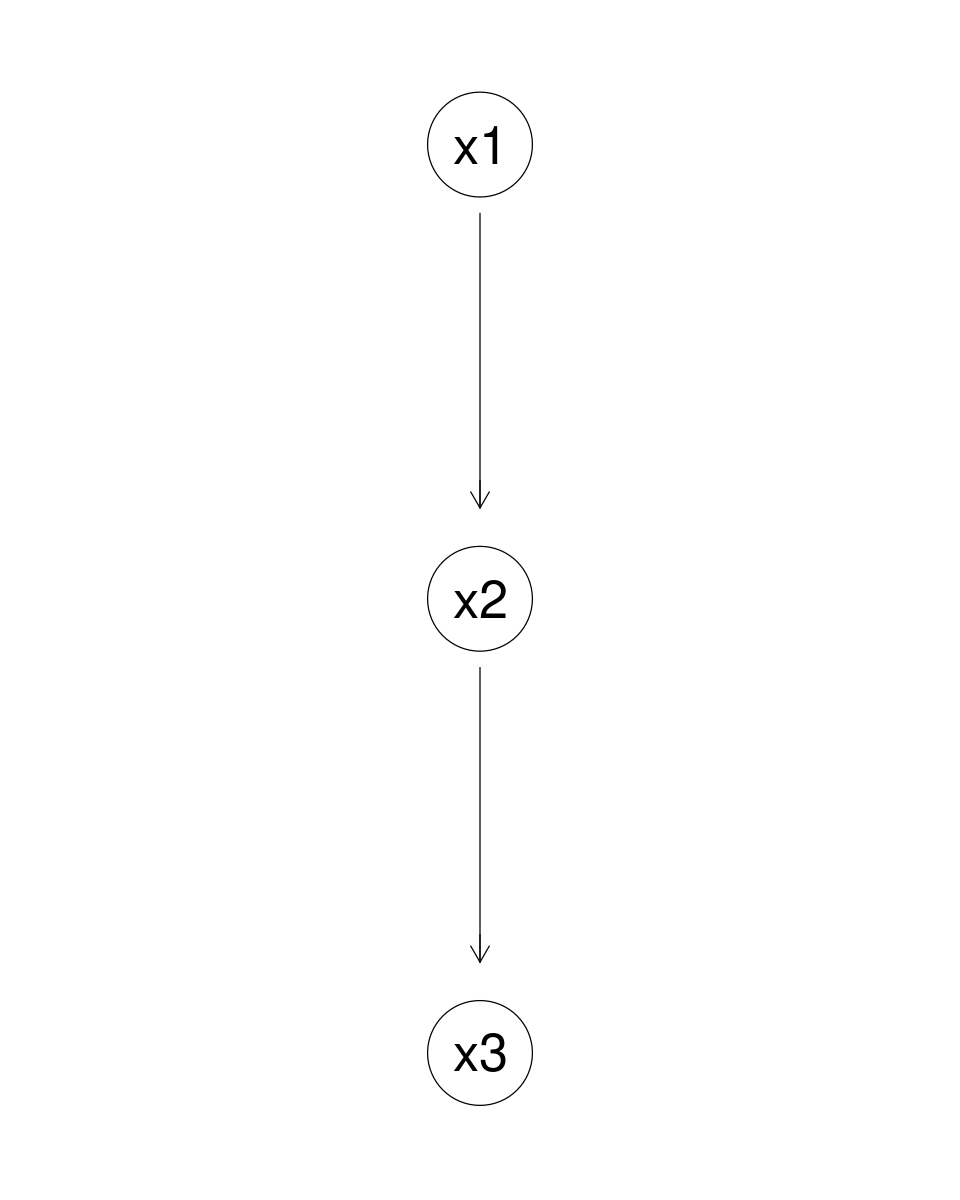

In [137]:
options(repr.plot.width=8, repr.plot.height=10)
graphviz.plot(bn_ruiz$dag, fontsize=10)

We obtain what was expected, so we apply our implementation of the K2 algorithm to more complex datasets:
- Child
- Asia <br>

Both present in the R-library `bnstruct`

<a id='Child'></a>
# 3. Application to Child dataset
## Index:
1. [Upload and preprocessing of the dataset](#Upload_preprocessing_child)
2. [Test custom made K2 algorithm](#K2_child)
3. [True Bayesian Network from `bnlearn`](#True_child)
4. [DAG comparison: true vs. custom made algorithm](#Comparison_true_child)
5. [K-2 scoring algorithm in `bnlearn`](#K2_bnlearn_child)
6. [DAG comparison: custom made algorithm vs. `bnlearn` built-in function](#Comparison_child)
7. [BIC DAG score](#BIC_child)
8. [Use of Imputed data](#Impute_child)
9. [Score comparison of different # events of non-imputed data](#Score_child)

The Child dataframe is part of a study with the Great Ormond Street (GOS) Hospital for Sick Children in London. The hospital acts as a referral centre for newborn babies with congenital heart disease, and
since early appropriate treatment is essential, a preliminary diagnosis must be reached using information reported over the telephone; this data may concern clinical signs, blood gases, electrocardiogram (ECG) and x-ray. <br> 
An algorithm to help the junior doctor at GOS has already been developed and evaluated on 400 cases (Franklin et al., 1991). The results suggested that the use of a formal decision aid could be of substantial
benefit.



Diagnostic accuracy: 

| Algorithm | GOS' doctors | Referring Pediatrician |
| -------- | -------- | -------- |
| 76% | 64% | 45% |



The goal of the study was to create a graphical model that allows experts to concentrate on building up the qualitative structure of a problem, before even beginning to address issues of quantitative specification. 

The subsequent figure shows a preliminary network for part of the spectrum of diseases e.g.
  
- *Disease* includes six possible conditions, assumed mutually exclusive and exhaustive, that lead to particularly "blue" babies.
- The level of oxygen in the lower body (*LowerBody02*) is directly related to the underlying level when breathing oxygen (*HypoxiaInO2*) and whether the hypoxia is equally distributed around the body(*HypDistrib*).
- The level when breathing oxygen depends on the degree of mixing of the blood in the heart (*CardiacMixin*) and the state of the blood vessels (parenchyma) in the lungs (*LungParench'*). 
- These intermediate variables are directly influenced by the underlying *Disease*

The aim of the CHILD network is to provide a mechanism so that both clinical expertise and available data can be properly exploited to produce a reasonably transparent diagnostic aid. 

https://www.bnlearn.com/bnrepository/discrete-medium.html

![My Image](Pictures/Child-real-network.png)

Our goal is to use K2-algorithm to find the connections between the different variables of our dataset and evaluate the affidability of the decision made using the obtained DAG.

<a id='Upload_preprocessing_child'></a>
## 3.1. Upload and preprocessing of the dataset 

1. We load the CHILD dataset from the `bnstruct` package.\
Notice that for the K-2 implementation, we need to create a `BNDataset` object of `bnstruct`, and the dataframe must be of numeric type. On the other hand, `bnlearn` works with datasets of _factors_ type.
2. In both cases, we first consider the case in which there are no missing values (i.e. NAs, or "?" for factors). Later on, we will use _imputation_ to fill the missing values of the dataset from the other known values and structure.
3. We move the Age column to have a broader possible dependance on other variables and rename LVHReport as LVHreport to uniform the names of the variables between `bnlearn` and `bnstruct`
4. We create, after the required modifications, the BNDataset

In [138]:
options(repr.plot.width=10, repr.plot.height=13)

# load the child database from the bnstruct library
# it contains missing values which have to be handled
temp = child() 
child_data_na = data.frame(raw.data(temp))

# rename columns to uniform with later use
colnames(child_data_na) = c("BirthAsphyxia", "Disease", "Age", "LVH", "DuctFlow",
                           "CardiacMixing", "LungParench", "LungFlow", "Sick", "HypDistrib",
                           "HypoxiaInO2", "CO2", "ChestXray", "Grunting", "LVHreport",
                           "LowerBodyO2", "RUQO2", "CO2Report", "XrayReport", "GruntingReport") 

# drop rows with na values
child_data = drop_na(child_data_na)

child_neworder <- c("BirthAsphyxia", "Disease", "LVH", "DuctFlow",
                   "CardiacMixing", "LungParench", "LungFlow", "Sick", "Age", "HypDistrib",
                   "HypoxiaInO2", "CO2", "ChestXray", "Grunting", "LVHreport",
                   "LowerBodyO2", "RUQO2", "CO2Report", "XrayReport", "GruntingReport")

# change order of columns
child_data <- child_data[, child_neworder]


In [69]:
node_sizes <- c(2, 6, 2, 3, 4, 3, 3, 2, 3, 2, 3, 3, 5, 2, 2, 3, 3, 2, 5, 2)

# create a BNDataset object for K2
child_k2 <- BNDataset(data = child_data, discreteness = temp@discreteness, variables=child_neworder, node.sizes= node_sizes)

<a id='K2_child'></a>
## 3.2. Test custom made K2 algorithm
Now perform the inference with the K2 algorithm. 

In [70]:
result <- create_k2_dag(child_k2, 2, child_k2@variables)

<a id='True_child'></a>
## 3.3 True Bayesian Network from `bnlearn`
We load the suggested graph for the Child datset from the literature as appears in the bnlearn repository https://www.bnlearn.com/bnrepository/discrete-medium.html#child

In [11]:
# import the data as a bn.fit object
child_true <- bnlearn::read.bif("data/child.bif")

# transform the bn.fit object to a graphAM object of class graph to plot
child_graph <- as.graphAM(child_true)

# retrieve the adjacency matrix with the names of the variables
child_matr <- child_graph@adjMat

In [12]:
child_varnames <- colnames(child_matr)

rownames(child_matr) <- colnames(child_matr)

# change the order of rows and columns 
child_matr <- child_matr[child_neworder, child_neworder]

<a id='Comparison_true_child'></a>
## 3.4 DAG comparison: true vs. custom made algorithm

Now we have both the true graph and the k2 graph as `bn` objects, therefore we can compare the two methods.

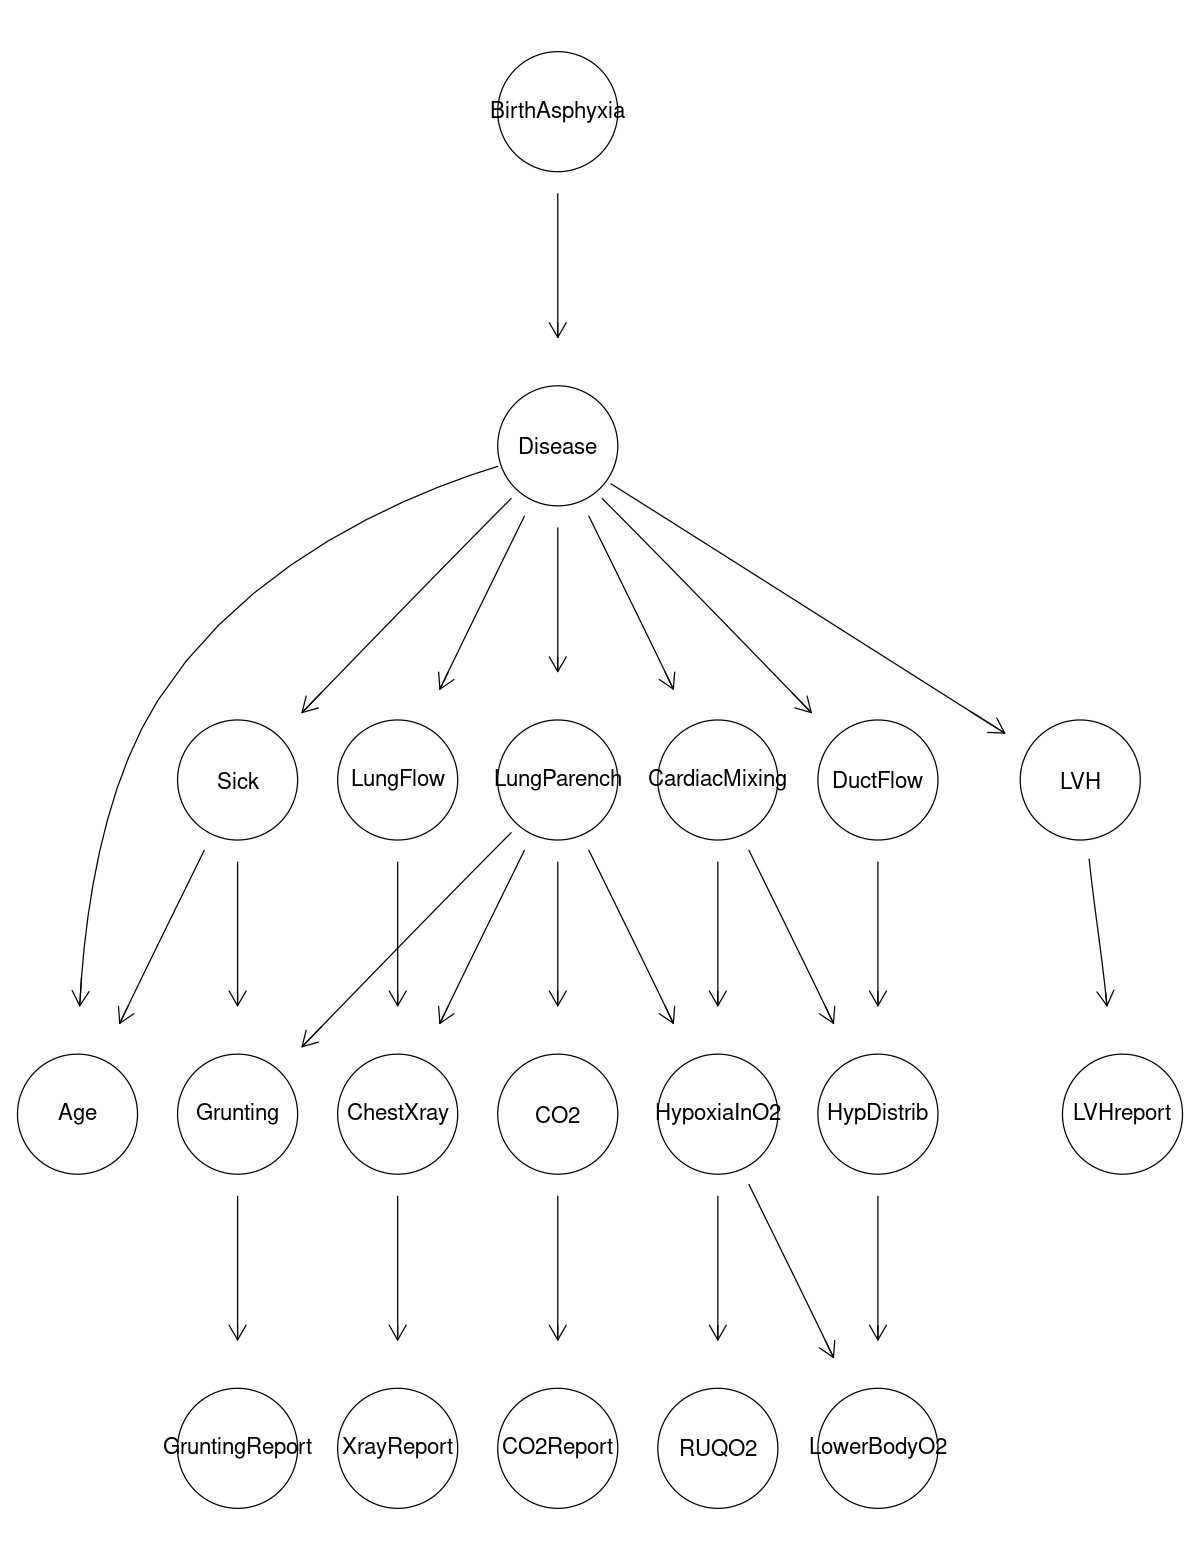

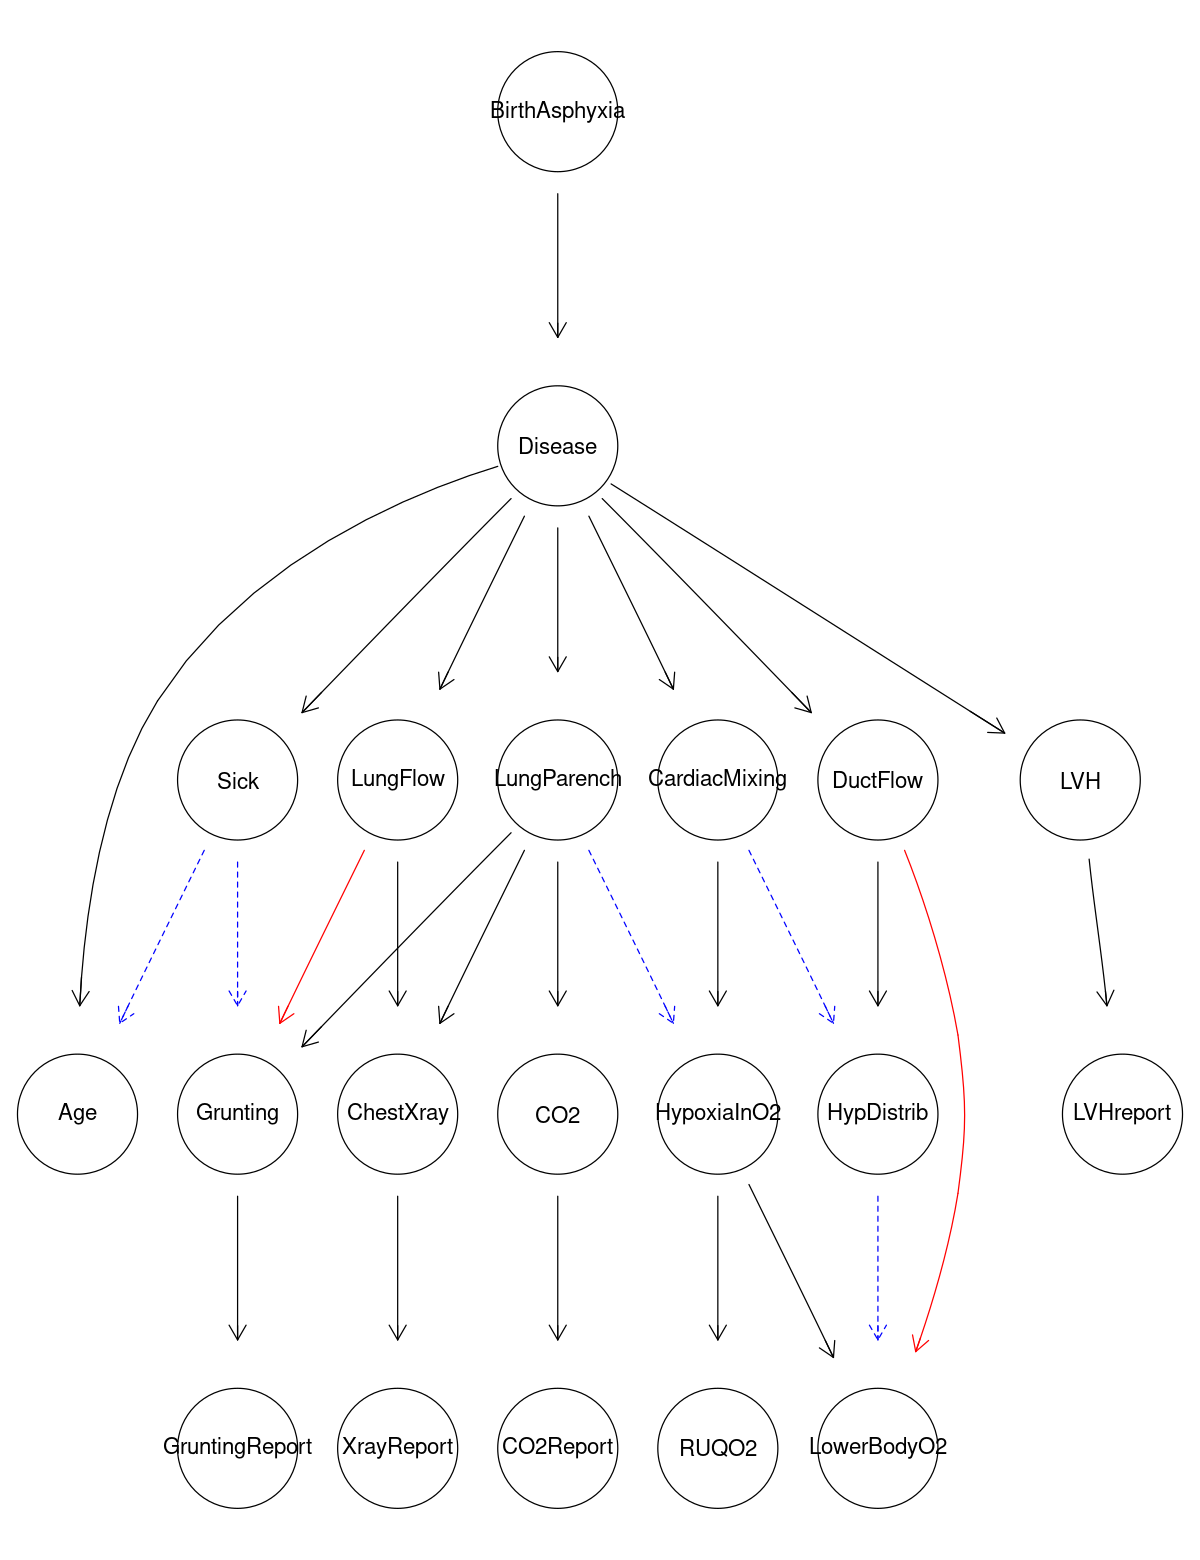

In [139]:
# transofrm bn.fit object in bn object
true_child_bn <- bn.net(child_true)

# compare the graphs
comp <- graphviz.compare(true_child_bn, result$dag, fontsize=30)

In the above figure, the red arcs indicate connections found with the custom algorithm that are not present in the true graph, and the blue once vice versa.\
We can see that there are a number of both missing and additional arcs in the inferred graph with respect to the true one, but the algorithm is able to capture the general structure of the network.

<a id='K2_bnlearn_child'></a>
##  3.5 K-2 scoring algorithm in `bnlearn`
We use now the function present in the `bnlearn` package, with K-2 as the scoring method, to learn the structure and parameters of the network. We use the same data provided to our algorithm, to check the consistency of our result. <br>
Notice that for the `bnlearn` package to work, we must provide data as factors type.

In [120]:
# transform the data to discrete factors to be used in bnlearn
child_fac <- as.data.frame(lapply(child_data, as.factor))

# create the "prior" blacklist as used before for the k2
# i.e. a 2 column dataframe with all the possible parent to child arcs that we DO NOT want

bl <- ordering2blacklist(child_neworder)

# learn the structure of the network
bnlearn_child_bn <- hc(child_fac, score = "k2", blacklist = bl)

<a id='Comparison_child'></a>
## 3.6 DAG comparison: custom made algorithm vs. `bnlearn` built-in function

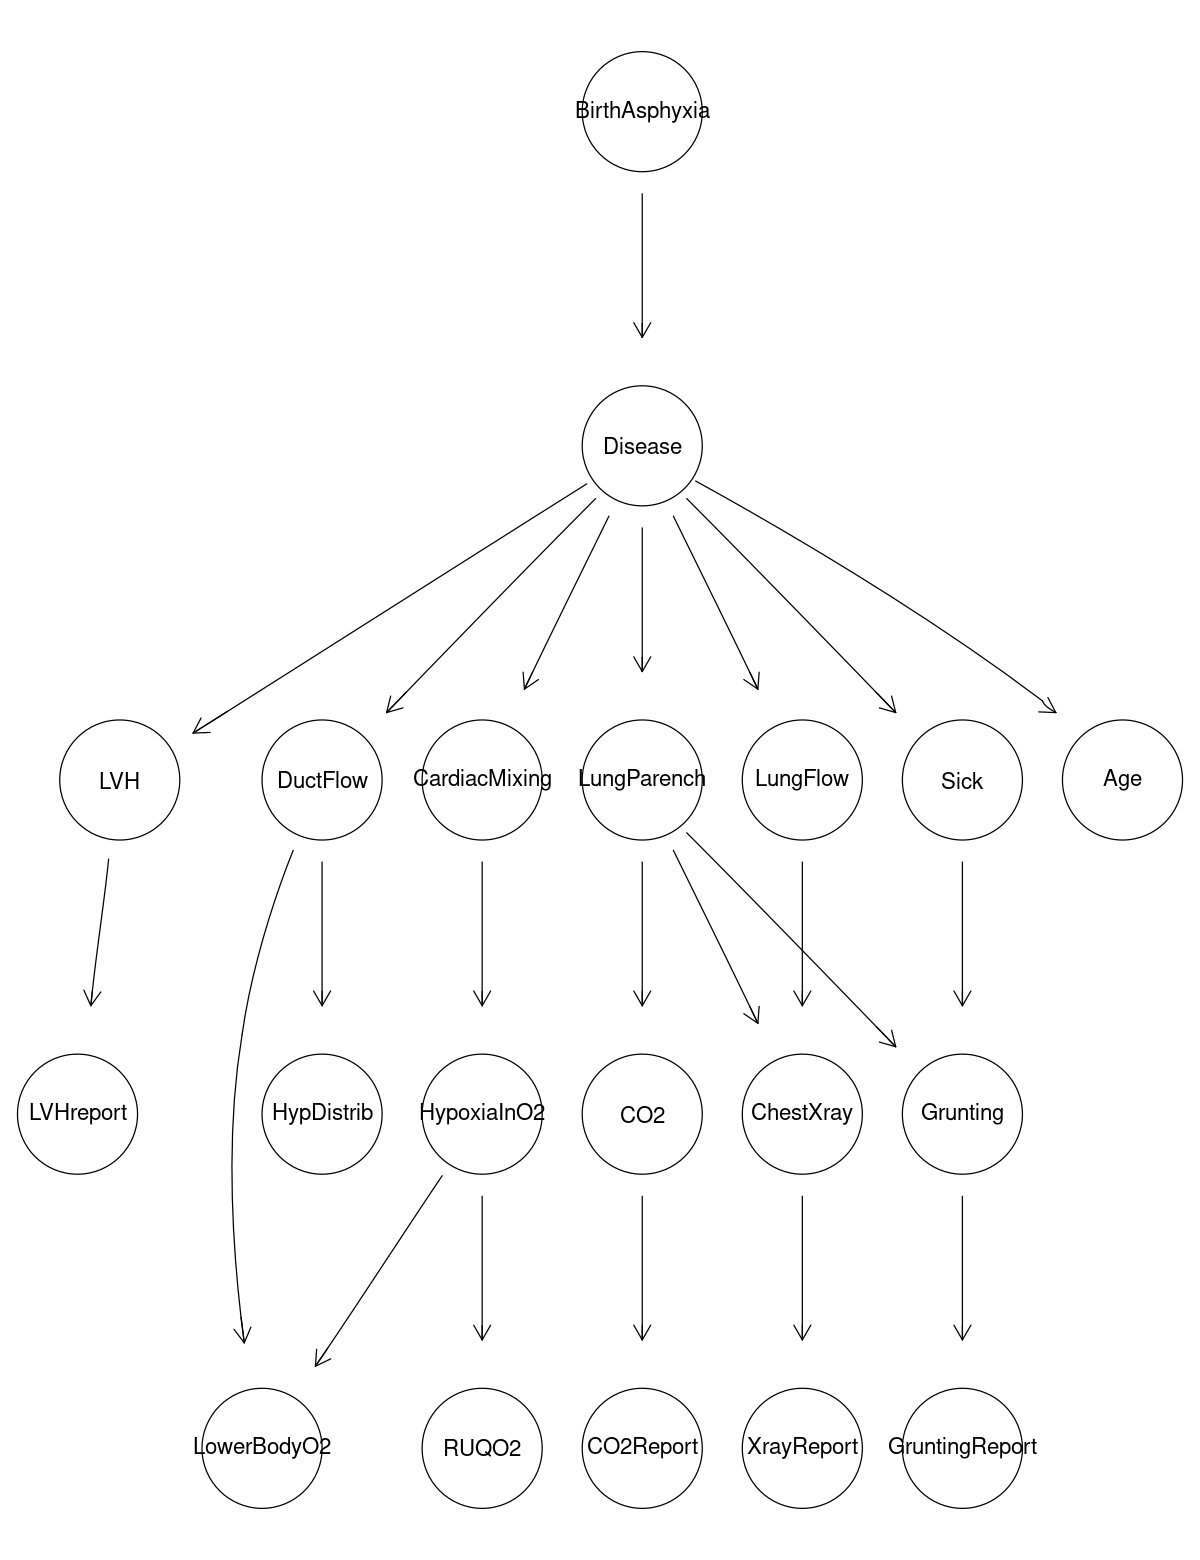

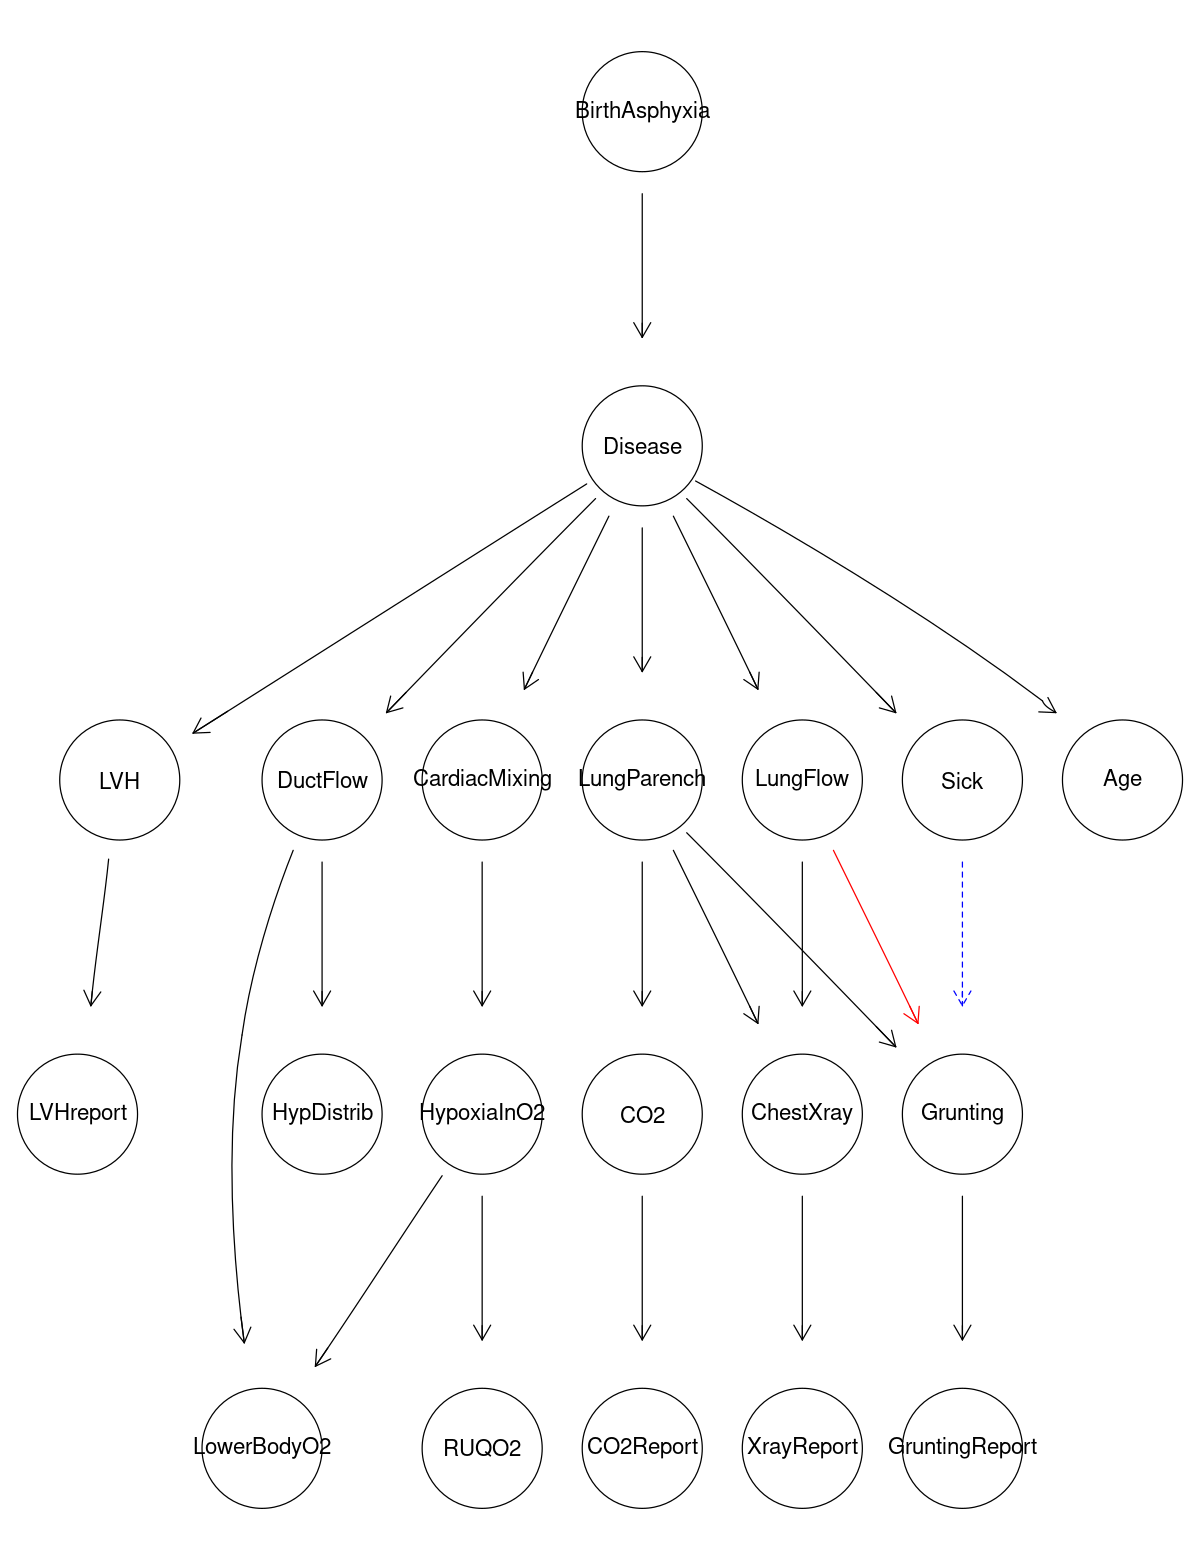

In [140]:
# compare the graphs

graphviz.compare(bnlearn_child_bn, result$dag, fontsize=30)

The graphs are indeed highly similar, suggesting the substantial correctness of the implementation.

<a id='BIC_child'></a>
## 3.7 BIC DAG score

We compute the *BIC* (Bayesian Information Criterion, introduced by Schwarz in 1978) as one of the possible metrics to evaluate the correctness of the graph found with the K-2 algorithm with respect to the one suggested in the literature. Moreover, we can `set` and `drop` the arcs of our graph to evaluate whether moving towards the suggested graph gives better results with this metric.\
To do so, we use the `score()` function from the `bnlearn` package [Chickering DM,1995].

- For a structure $G$, we define the likhelihood $L$ of the observed data as a function of $G$, $\vec{C}=\{C_1,....,C_N\}$ and the parameters $\theta_G$ as follows: $$L(G,\theta_G,\vec{C})=p(\vec{C}|G^h,\theta_G)$$ where $G^h$ is the hypotesis that the data was generated by a distribution that can be factored according to $G$.
- The _maximum likhelihood_ metric for a structure $G$ is defined as $$M_{ML}(G,\vec{C})=\max_{\theta_G}L(G,\theta_G,\vec{C})$$
- Then the BIC is defined as: $$M_{BIC}(G,\vec{C})=log M_{ML}(G,\vec{C})-\frac{1}{2}Dim(G)log N$$ with $N$ number of cases in $\vec{C}$.

In [205]:
# custom score
k2_score <- score(k2_child_bn, data = child_fac)

true_score <- score(true_child_bn, data = child_fac)

cat("Our k2 score:", k2_score, "\n")
cat("True score:", true_score)

Our k2 score: -2403.843 
True score: -2454.222

In [214]:
s <- c()
k2_improved <- k2_child_bn
k2_improved <- set.arc(k2_improved, from = "Sick", to = "Age")
s[1] <- score(k2_improved, data = child_data)

k2_improved <- set.arc(k2_improved, from = "Sick", to = "Grunting")
s[2] <- score(k2_improved, data = child_data)

k2_improved <- set.arc(k2_improved, from = "LungParench", to = "HypoxiaInO2")
s[3] <-score(k2_improved, data = child_data)

k2_improved <- set.arc(k2_improved, from = "CardiacMixing", to = "HypDistrib")
s[4] <-score(k2_improved, data = child_data)

k2_improved <- set.arc(k2_improved, from = "HypDistrib", to = "LowerBodyO2")
s[5] <- score(k2_improved, data = child_data)

k2_improved <- drop.arc(k2_improved, from = "LungFlow", to = "Grunting")
s[6] <- score(k2_improved, data = child_data)

k2_improved <- drop.arc(k2_improved, from = "DuctFlow", to = "LowerBodyO2")
s[7] <- score(k2_improved, data = child_data)

s

[1] -2428.844 -2442.428 -2470.778 -2485.020 -2525.599 -2501.483 -2454.222

The BIC score gives a better result for the graph inferred with our implementation of the K2 algorithm than for the true graph. In practice, the score is better if the graph explains better the given data, and indeed it might be that the inferred graph explains the data better than the true graph. However, since we have no information about how the true graph is obtained, it does not mean that the inferred graph is better in absolute terms.
Nevertheless, while BIC is a good estimator to employ to verify whether small variations on the network’s edges improve its likelihood, in this case it makes no sense to use it to compare the inferred graph to the theoretical graph, nor it can be used to compare the differences in the performance at a different size of the input dataset, since the BIC depends on it.

<a id='Impute_child'></a>
## 3.8 Use of imputed data
Now, we try to learn the structure of the network with the _imputation_ of missing values of the dataset, i.e. the prediction of missing values of some variables in the records from the value of the other nodes and the structure of the network.\
The dataset to impute is the same we used before from the `bnstruct` package, and the imputed one contains 5000 records [Franzin et al., 2017].

In [123]:
dataset <- child()
imputed <- bnstruct::impute(dataset, k.impute=10)

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



In [126]:
child_data_imp = data.frame(imputed.data(imputed))

# rename columns to uniform with later use
colnames(child_data_imp) = c("BirthAsphyxia", "Disease", "Age", "LVH", "DuctFlow",
                           "CardiacMixing", "LungParench", "LungFlow", "Sick", "HypDistrib",
                           "HypoxiaInO2", "CO2", "ChestXray", "Grunting", "LVHreport",
                           "LowerBodyO2", "RUQO2", "CO2Report", "XrayReport", "GruntingReport") 

# change order of columns
child_data_imputed <- child_data_imp[, child_neworder]

child_data_imputed_5000 <- child_data_imputed[sample(nrow(child_data_imputed), 5000), ]

child_k2_imputed_5000 <- BNDataset(data = child_data_imputed_5000, discreteness = dataset@discreteness, variables=child_neworder, node.sizes= node_sizes)

k2_child_5000_imp <- create_k2_dag(child_k2_imputed_5000, 2, child_neworder)

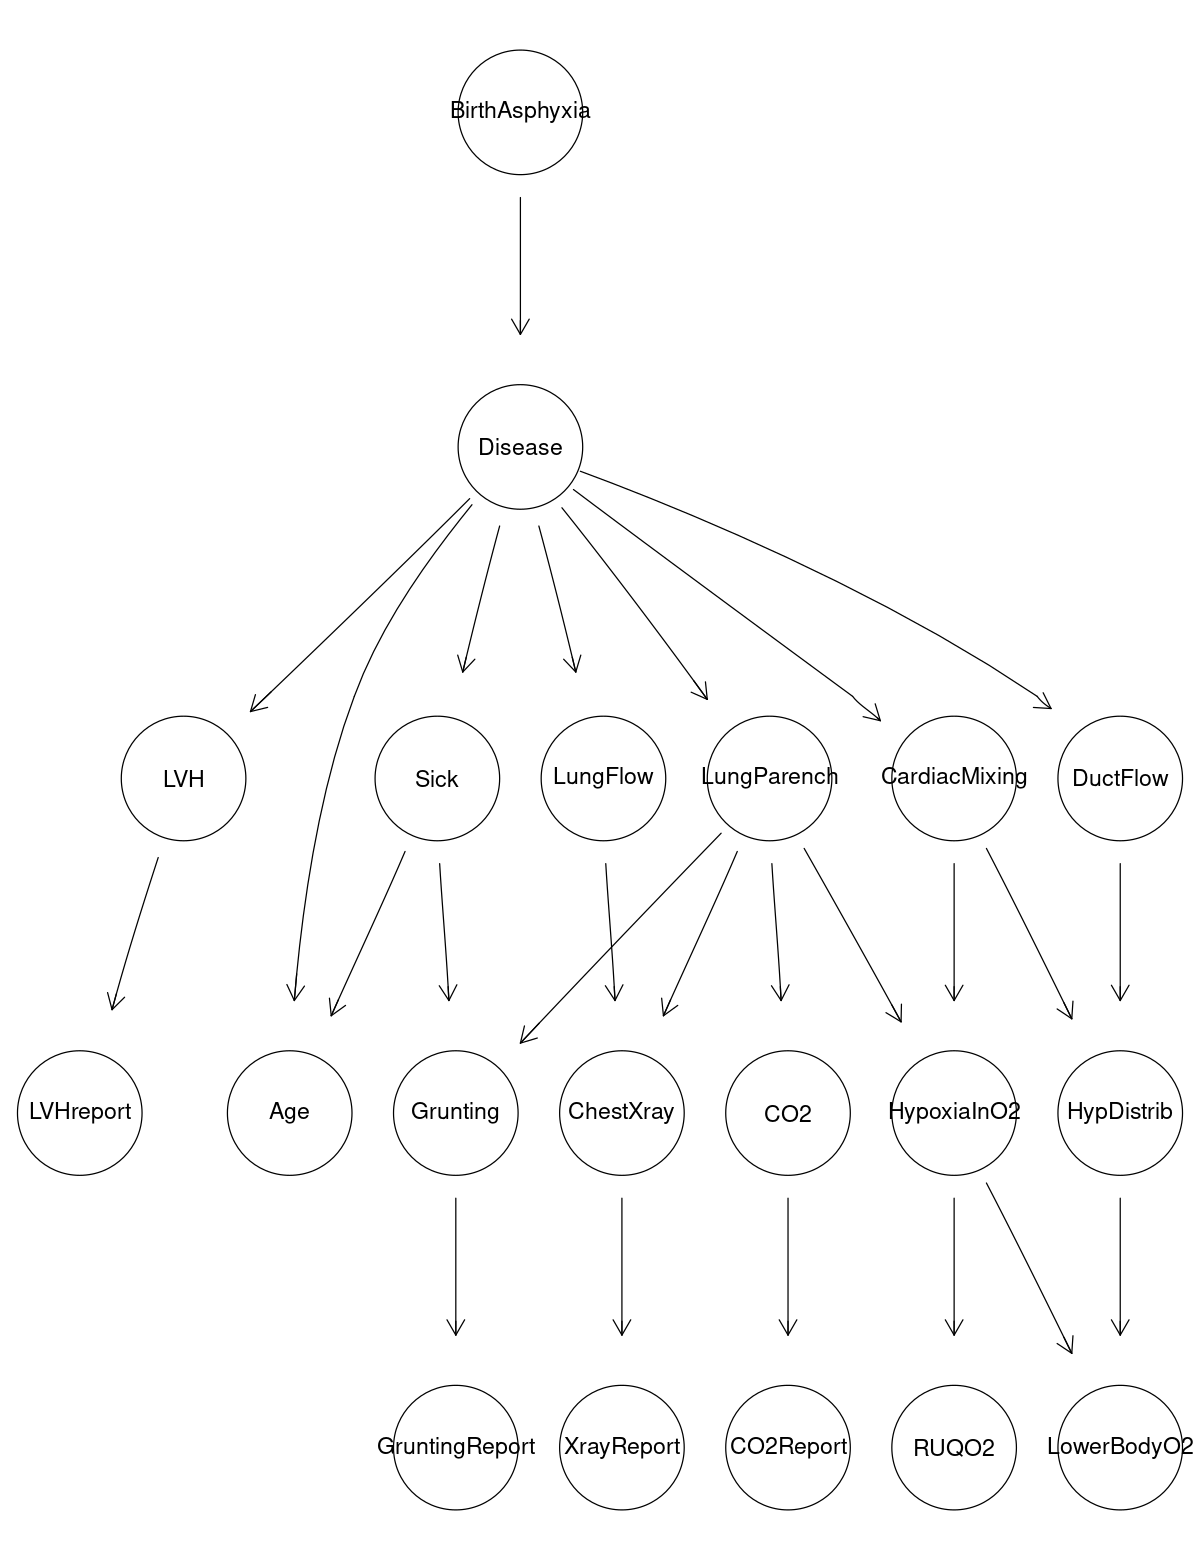

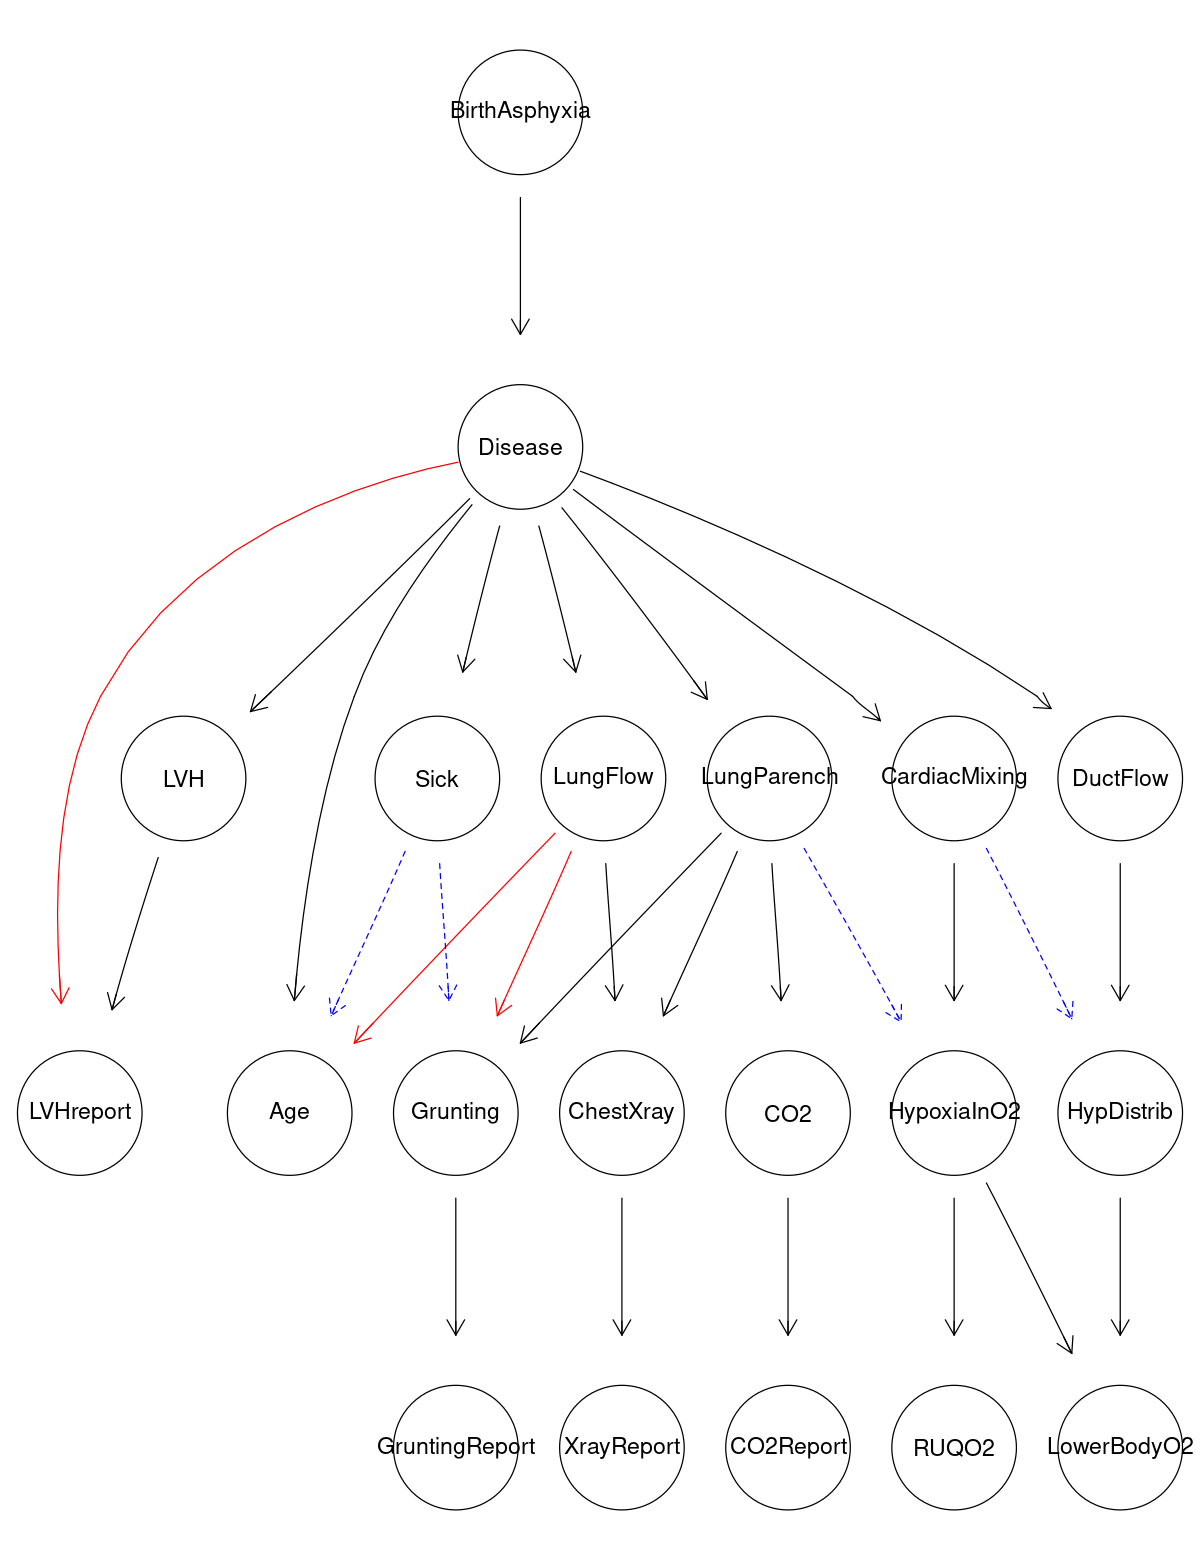

In [141]:
# compare the graphs
graphviz.compare(true_child_bn, k2_child_5000_imp$dag, fontsize=30)

We see that also in this case there is a significant number of wrong arcs, in spite of the fact that the datset size was much greater. Indeed it would be preferrable to estimate the performance in a quantitative manner, as done in the following section.

<a id='Score_child'></a>
## 3.9 Performance analysis on Child dataset

Here we calculate the number of errors between the inferred graph and the true graph made by using datasets of different sizes. In particular, the number of error of a DAG is defined as the number of missing arc plus the number of additional arcs.\
We compare the performance of our algorithm with the `bnlearn` algorithm.

In [21]:
# custom k2

child_errors <- data.frame(matrix(ncol = 2, nrow = 0))
colnames(child_errors) <- c("x", "y", "colour")

indices <- c(seq(20, 100, 20), 150, 200, 500, 1000, 5000)

for (i in indices) {

    child_data_subset <- child_data_imputed[sample(nrow(child_data_imputed), i), ]

    child_k2_imputed <- BNDataset(data = child_data_subset, discreteness = dataset@discreteness, variables=child_neworder, node.sizes= node_sizes)

    child_dag <- create_k2_dag(child_k2_imputed, 2, child_neworder)

    comp <- bnlearn::compare(true_child_bn, child_dag$dag)

    child_errors[nrow(child_errors) + 1,] <- c(i, comp$fp + comp$fn)
}


Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  2”
Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  2”
Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  2”
Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  2”


In [28]:
# transform the data to discrete factors to be used in bnlearn
child_imp_fac <- as.data.frame(lapply(child_data_imputed, as.factor))

# create the "prior" blacklist as used before for the k2
# i.e. a 2 column dataframe with all the possible parent to child arcs that we DO NOT want

bl <- ordering2blacklist(child_neworder)

# learn the structure of the network
bnlearn_child_bn <- hc(child_imp_fac, score = "k2", blacklist = bl)

In [29]:
# built-in k2

child_errors_bn <- data.frame(matrix(ncol = 2, nrow = 0))
colnames(child_errors_bn) <- c("x", "y", "colour")

indices <- c(seq(20, 100, 20), 150, 200, 500, 1000, 5000)

for (i in indices) {

    child_data_subset <- child_imp_fac[sample(nrow(child_imp_fac), i), ]

    bnlearn_child_bn <- hc(child_data_subset, score = "k2", blacklist = bl)

    comp <- bnlearn::compare(true_child_bn, bnlearn_child_bn)

    child_errors_bn[nrow(child_errors_bn) + 1,] <- c(i, comp$fp + comp$fn)
}

Warning message in check.data(x, allow.missing = TRUE):
“variable CardiacMixing in the data has levels that are not observed in the data.”
Warning message in check.data(x, allow.missing = TRUE):
“variable HypoxiaInO2 in the data has levels that are not observed in the data.”


In [ ]:
child_errors$colour <- rep("custom k2", times = nrow(child_errors))
child_errors_bn$colour <- rep("built-in k2", times = nrow(child_errors_bn))

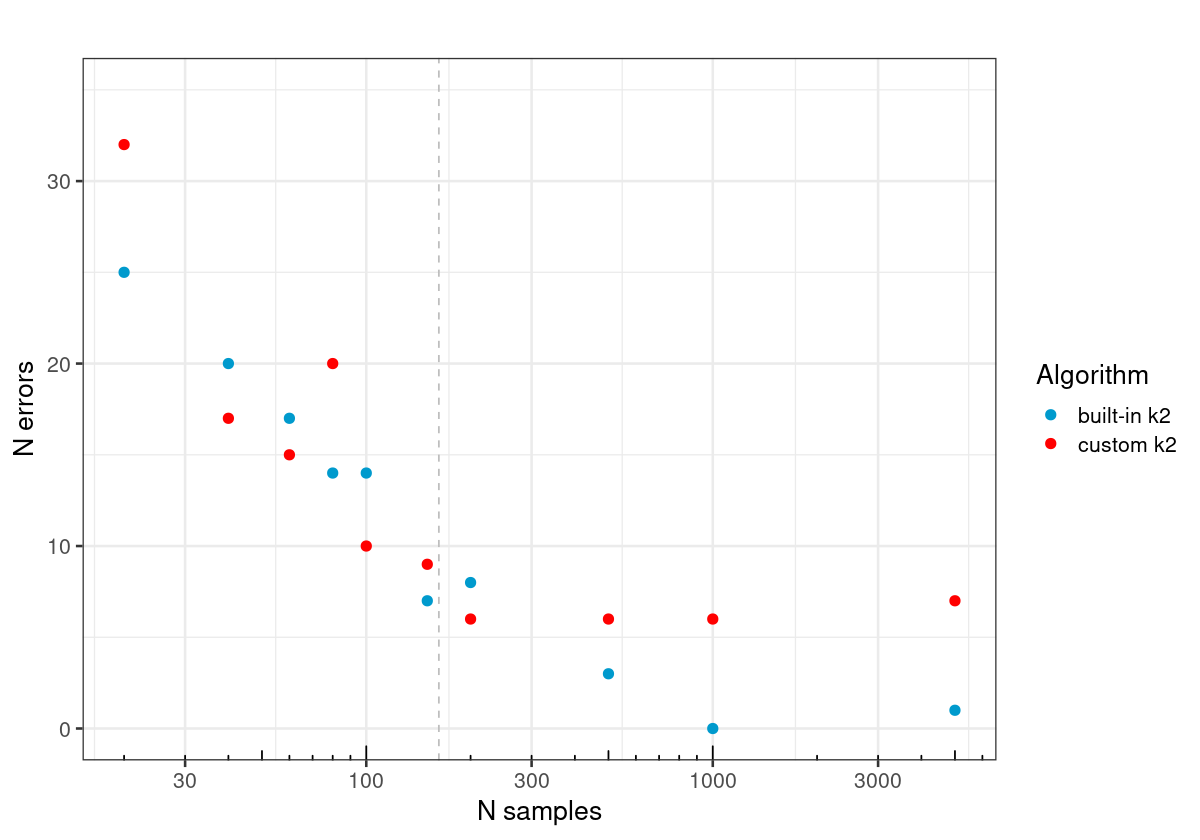

In [145]:
new_child_errors <- rbind(child_errors, child_errors_bn)
my_ggplot(new_child_errors, "Algorithm", xlab = "N samples", ylab = "N errors", title = "", logx = TRUE, ylim_min = 0, ylim_max = 35, vline=162)

As expected, the number of errors decreases as the number of sample increases. However, the imputing operation does not seem to improve the performance of our custom k2 algorithm. On the other hand, the custom k2 does not display a significant difference with the built-in k2 when no imputation is applied, suggesting that our algorithm works correctly. However, as we increase artificially the size of the dataset, the built-in k2 algorithm seems to perform much better.

<a id='Asia'></a>
# 4. Application to Asia Dataset
## Index:
1. [Upload and preprocessing of the dataset](#Upload_preprocessing_asia)
2. [Test custom made K2 algorithm](#K2_asia)
3. ["True" Bayesian Network from `bnlearn`](#True_asia)
4. [DAG comparison: true vs. custom made algorithm](#Comparison_true_asia)
5. [K-2 scoring algorithm in `bnlearn`](#K2_bnlearn_asia)
6. [DAG comparison: custom made algorithm vs. `bnlearn` built-in function](#Comparison_asia)
7. [Score comparison of different # events of non-imputed data](#Score_asia)

Lauritzen and Spiegelhalter (1988) motivate this example as follows:

“Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or bronchitis, or none of them, or more than one of them. A recent visit to Asia increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.”

The asia data set contains the following variables, all two-levels factors with levels yes or no

![My Image](Pictures/Asia-real-network.png)

<a id='Upload_preprocessing_asia'></a>
## 4.1 Upload and preprocessing of the dataset
1. We load the Asia dataset from the `bnstruct` package.\
Notice that for the K-2 implementation, we need to create a `BNDataset` object of `bnstruct`, and the dataframe must be of numeric type. On the other hand, `bnlearn` works with datasets of _factors_ type.
2. We create, after the required modifications, the BNDataset


In [142]:
options(repr.plot.width=8, repr.plot.height=10)

# load the asia database from the bnstruct library
temp = asia() 
asia_data = data.frame(raw.data(temp))
asia_data <- drop_na(asia_data)

In [50]:
asia_order <- temp@variables
asia_node_sizes <- temp@node.sizes

colnames(asia_data) <- asia_order

The columns are already at the correct parent $\rightarrow$ child order, no further manipulation is needed.

<a id='K2_asia'></a>
## 4.2. Test custom made K2 algorithm
Now perform the inference with the K2 algorithm. 

In [51]:
# create a BNDataset object for K2
asia_k2 <- BNDataset(data = asia_data, discreteness = temp@discreteness, variables=asia_order, node.sizes= asia_node_sizes)

In [72]:
k2_asia_bn <- create_k2_dag(asia_k2, 2, asia_k2@variables)

<a id='True_asia'></a>
## 4.3 True Bayesian Network from `bnlearn`
We load the suggested graph for the Child datset from the literature as appears in the bnlearn repository https://www.bnlearn.com/documentation/man/asia.html

In [55]:
# import the data as a bn.fit object
asia_true <- bnlearn::read.bif("data/asia.bif")

# transform the bn.fit object to a graphAM object of class graph to plot
asia_graph <- as.graphAM(asia_true)

# retrieve the adjacency matrix with the names of the variables
asia_matr <- asia_graph@adjMat

In [57]:
asia_true <- rename.nodes(asia_true, asia_order)

[1] "Asia"         "Tubercolosys" "Smoke"        "LungCancer"   "Bronchitis"  
[6] "Either"       "X-ray"        "Dyspnea"

<a id='Comparison_true_asia'></a>
## 4.4 DAG comparison: true vs. custom made algorithm

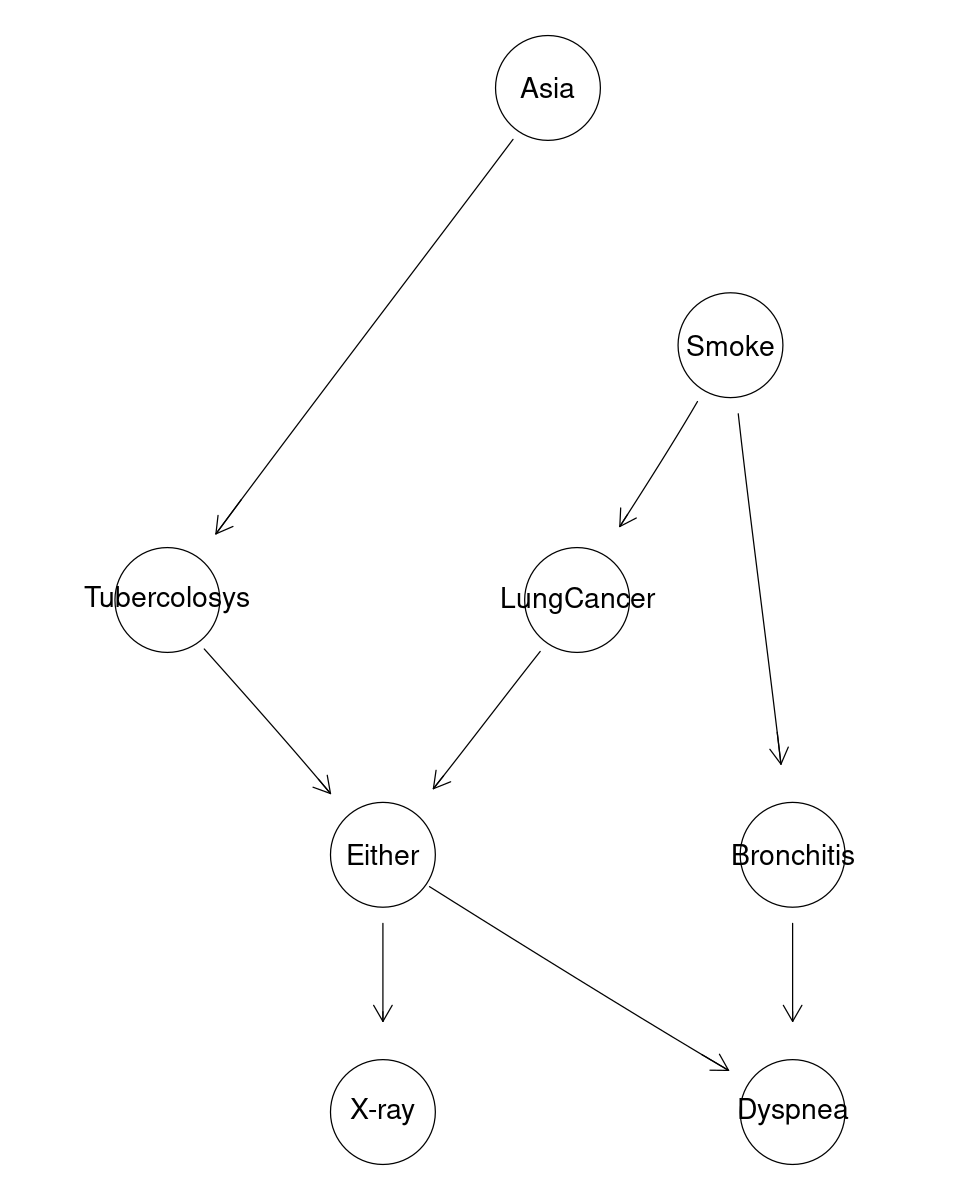

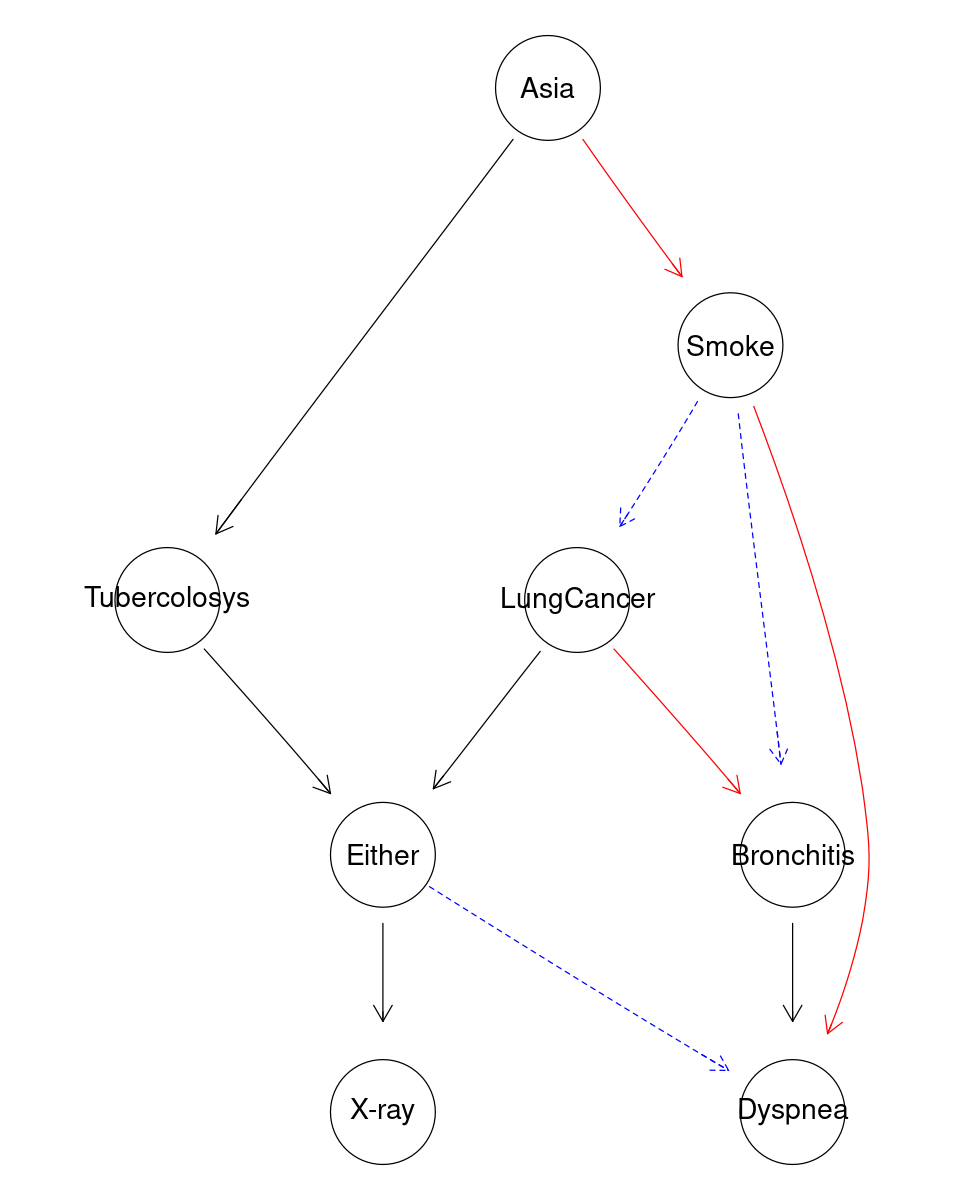

In [143]:
# transofrm bn.fit object in bn object
true_asia_bn <- bn.net(asia_true)

# compare the graphs

comp <- graphviz.compare(true_asia_bn, k2_asia_bn$dag, fontsize=30)

In this case, we see that a high number of arc has not been inferred correctly. However the general structure has been reasonably captured. 

<a id='K2_bnlearn_asia'></a>
##  4.5 K-2 scoring algorithm in `bnlearn`
We use now the function present in the `bnlearn` package, with K-2 as the scoring method, to learn the structure and parameters of the network. We use the same data provided to our algorithm, to check the consistency of our result. <br>
Notice that for the `bnlearn` package to work, we must provide data as factors type.

In [60]:
# transform the data to discrete factors to be used in bnlearn
asia_fac <- as.data.frame(lapply(asia_data, as.factor))

colnames(asia_fac) <- asia_order

# create the "prior" blacklist as used before for the k2
# i.e. a 2 column dataframe with all the possible parent to child arcs that we DO NOT want

bl <- ordering2blacklist(asia_order)

# learn the structure of the network
bnlearn_asia_bn <- hc(asia_fac, score = "k2", blacklist = bl)

<a id='Comparison_asia'></a>
## 4.6 DAG comparison: custom made algorithm vs. `bnlearn` built-in function

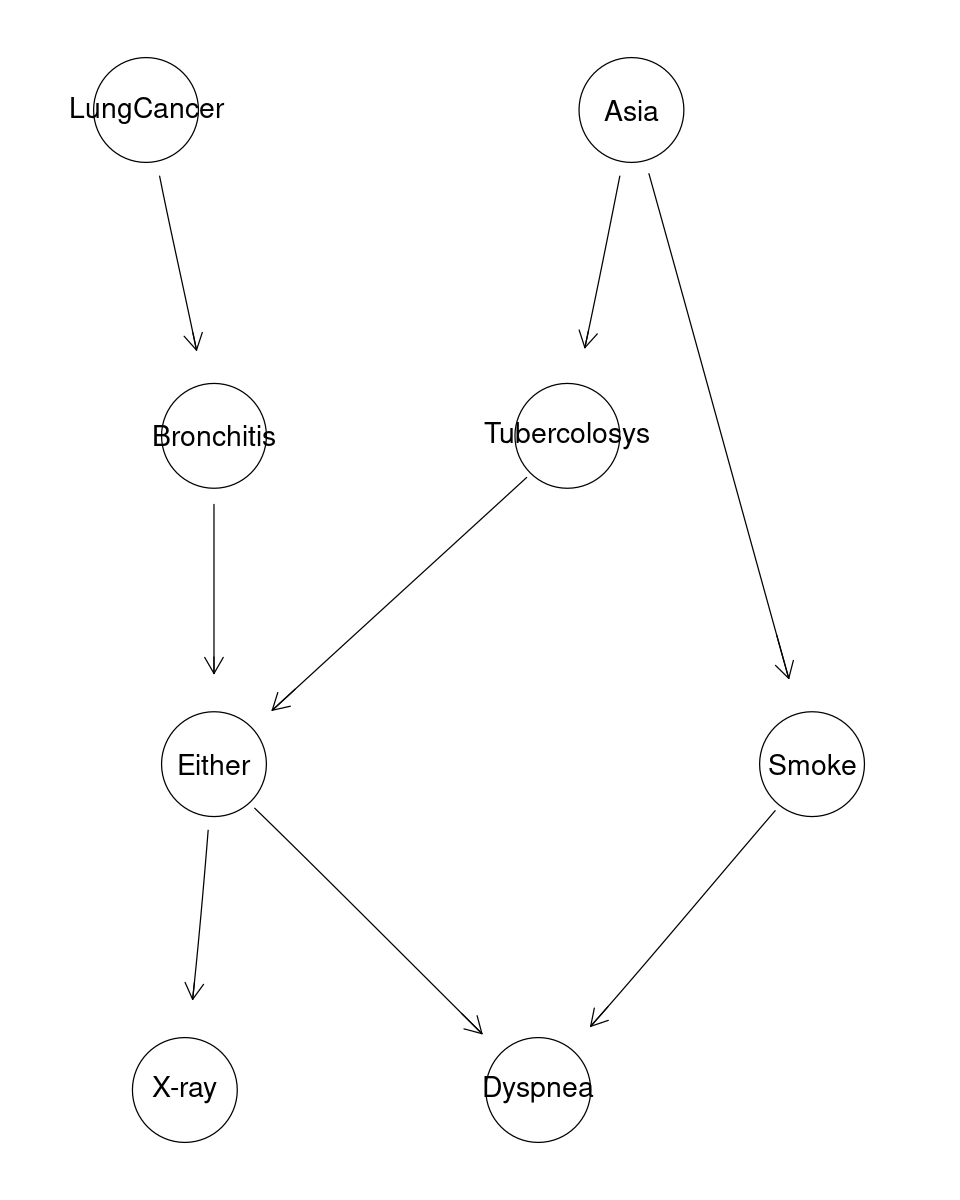

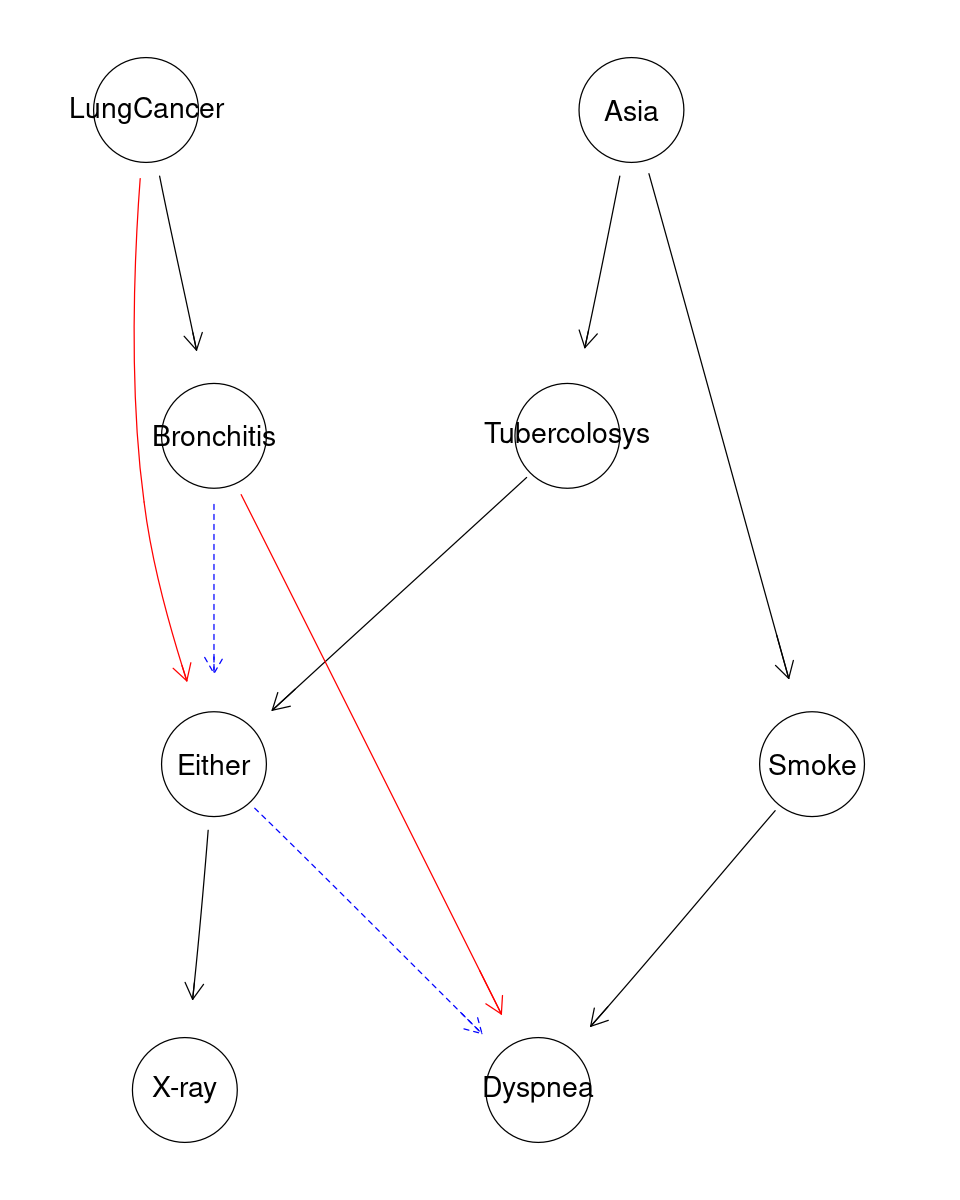

In [144]:
# compare the graphs
graphviz.compare(bnlearn_asia_bn, k2_asia_bn$dag, fontsize=30)

As before, also in this case the custom algorithm and the built-in disagree on the connection of a non-negligible number of nodes. 

<a id='Score_asia'></a>
## 4.7 Performance analysis on Asia dataset


In [ ]:
# custom k2
asia_errors <- data.frame(matrix(ncol = 2, nrow = 0))
colnames(asia_errors) <- c("x", "y", "colour")

indices <- c(seq(20, 80, 20), seq(100, 1000, 100), seq(1500, 10000, 500))

for (i in indices) {

    asia_k2_dat <- BNDataset(data = asia_data[1:i,], discreteness = temp@discreteness, variables=asia_order, node.sizes= asia_node_sizes)

    asia_dag <- create_k2_dag(asia_k2_dat, 2, asia_order)

    comp <- bnlearn::compare(true_asia_bn, asia_dag$dag)

    asia_errors[nrow(asia_errors) + 1,] <- c(i, comp$fp + comp$fn)
}


In [ ]:
# built in k2
asia_errors_bn <- data.frame(matrix(ncol = 2, nrow = 0))
colnames(asia_errors_bn) <- c("x", "y", "colour")

indices <- c(seq(20, 80, 20), seq(100, 1000, 100), seq(1500, 10000, 500))

for (i in indices) {

    asia_data_subset <- asia_fac[sample(nrow(asia_fac), i), ]

    bnlearn_asia_bn <- hc(asia_data_subset, score = "k2", blacklist = bl)

    comp <- bnlearn::compare(true_asia_bn, bnlearn_asia_bn)

    asia_errors_bn[nrow(asia_errors_bn) + 1,] <- c(i, comp$fp + comp$fn)
}

In [99]:
asia_errors_mean <- logbin_double(asia_errors$x, asia_errors$y, bin_width = 0.33)
asia_errors_bn_mean <- logbin_double(asia_errors_bn$x, asia_errors_bn$y, bin_width = 0.33)

asia_errors_mean <- filter(asia_errors_mean, y > 0)
asia_errors_bn_mean <- filter(asia_errors_bn_mean, y > 0)

asia_errors_mean <- mutate(asia_errors_mean, colour = "custom k2")
asia_errors_bn_mean <- mutate(asia_errors_bn_mean, colour = "built-in k2")

new_asia_errors <- rbind(asia_errors_mean, asia_errors_bn_mean)

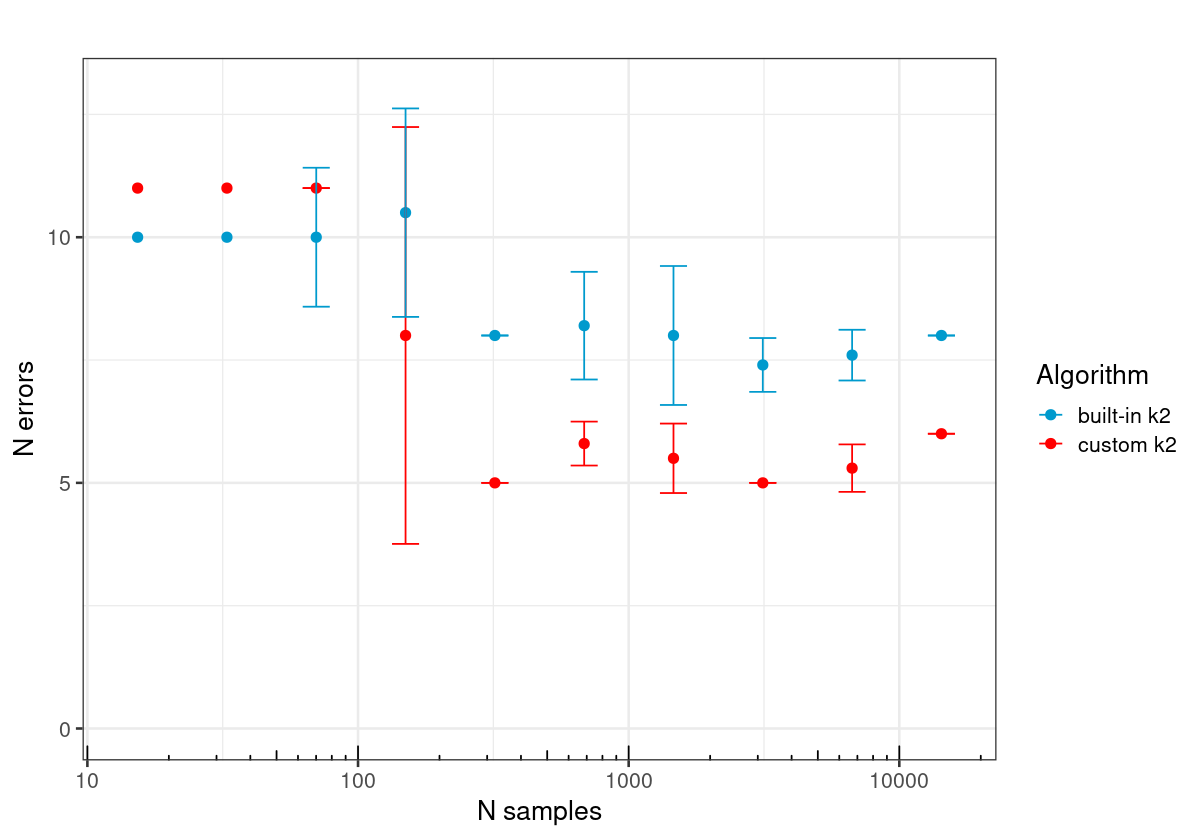

In [106]:
my_ggplot(new_asia_errors, "Algorithm", xlab = "N samples", ylab = "N errors", title = "", logx = TRUE, errors = TRUE, ylim_min = 0, ylim_max = 13)

We have binned the results for visualization purposes. In particular, the error bars indicate the standard deviations of points within each bin. In this case we see that there is an initial decrease in the number of errors as the number of samples considered increases, but then the curve reaches a plateau where no further improvement occurs. Note that there does not seem to be a great difference between the two methods; however the custom algorithm rather tends to perform better overall than the built-in one.